In [1]:
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np
import tqdm
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
rnps1 = pd.read_csv('./20241124_RNPS1OE_2v2_APA_table_hg38.txt', sep='\t')

In [3]:
figure_out_dir = './rnps1_oe_figures/'

In [4]:
def return_class(df):
    if df['log(treatment.p/treatment.d)'] > df['log(Ctrl.p/Ctrl.d)']:
        return 'proximal'
    elif df['log(treatment.p/treatment.d)'] < df['log(Ctrl.p/Ctrl.d)']:
        return 'distal'

In [5]:
def process_pas_table(df):
    df['treatment.p + 1'] = df['treatment.p'] + 1
    df['treatment.d + 1'] = df['treatment.d'] + 1
    df['Ctrl.p + 1'] = df['Ctrl.p'] + 1
    df['Ctrl.d + 1'] = df['Ctrl.d'] + 1
    df['log(treatment.p/treatment.d)'] = df.apply(lambda x: np.log2(x['treatment.p + 1']/x['treatment.d + 1']), axis=1)
    df['log(Ctrl.p/Ctrl.d)'] = df.apply(lambda x: np.log2(x['Ctrl.p + 1']/x['Ctrl.d + 1']), axis=1)
    df['apa_class'] = df.apply(return_class, axis=1)
    df['apa_type'] = df.apply(lambda x: f"{x['TYPE.p']}_{x['TYPE.d']}", axis=1)
    
    return df

In [6]:
rnps1_pas = process_pas_table(rnps1)

In [7]:
rnps1_pas.head()

,SYMBOL,GENEID,TYPE.p,COORD.p,Order.p,FDR.p,Ctrl.p,treatment.p,Ctrl_PCT.p,treatment_PCT.p,...,treatment_PCT.d,Change.d,treatment.p + 1,treatment.d + 1,Ctrl.p + 1,Ctrl.d + 1,log(treatment.p/treatment.d),log(Ctrl.p/Ctrl.d),apa_class,apa_type
0,AASS,ENSG00000008311,Intron,chr7:122143772:-,1,0.012500,0,42,0.000,0.792,...,0.075,0.675,43,5,1,22,3.104337,-4.459432,proximal,Intron_LastExon
1,AC008575.2,ENSG00000272869,Intron,chr5:112867908:+,8,0.675884,86,20,0.768,0.645,...,0.323,-0.305,21,11,87,3,0.932886,4.857981,distal,Intron_Intron
2,AC024592.3,ENSG00000267740,Intron,chr19:5894702:-,5,0.000266,11,282,0.011,0.224,...,0.767,0.213,283,967,12,965,-1.772714,-6.329423,proximal,Intron_Intron
3,AC135178.2,ENSG00000263809,Intron,chr17:8377604:-,6,0.004296,1865,336,0.187,0.038,...,0.896,-0.272,337,7838,1866,6228,-4.539665,-1.738820,distal,Intron_Intron
4,ACAD9,ENSG00000177646,LastExon,chr3:128913015:+,6,0.048271,35,47,0.191,0.588,...,0.237,0.195,48,20,36,80,1.263034,-1.152003,proximal,LastExon_LastExon


In [8]:
def switch_to_intron(pas_data):
    if (pas_data['apa_class']=='proximal') and (pas_data['TYPE.p']=='Intron'):
        return True
    elif (pas_data['apa_class']=='distal') and (pas_data['TYPE.d']=='Intron'):
        return True
    else:
        return False

In [9]:
rnps1_pas['intronic_switch'] = rnps1_pas.apply(switch_to_intron, axis=1)
rnps1_pas = rnps1_pas[rnps1_pas['intronic_switch']==True]
rnps1_pas['key'] = rnps1_pas.apply(lambda x: f"{x['SYMBOL']}_{x['GENEID']}_{x['apa_class']}", axis=1)

/tmp/ipykernel_1174619/2106064106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnps1_pas['key'] = rnps1_pas.apply(lambda x: f"{x['SYMBOL']}_{x['GENEID']}_{x['apa_class']}", axis=1)


In [10]:
def parse_coord(coord):
    coord_components = coord.split(':')
    chrom, start, stop, strand = coord_components[0], int(coord_components[1]), int(coord_components[1]) + 1, coord_components[2]
    return chrom, start, stop, strand


In [11]:
pas_event_count_toplot = rnps1_pas.groupby(['apa_class', 'apa_type']).count().reset_index()[['apa_class', 'apa_type', 'SYMBOL']].set_index('apa_type').sort_values('SYMBOL', ascending=False)

In [12]:
rnps1_pas.head()

,SYMBOL,GENEID,TYPE.p,COORD.p,Order.p,FDR.p,Ctrl.p,treatment.p,Ctrl_PCT.p,treatment_PCT.p,...,treatment.p + 1,treatment.d + 1,Ctrl.p + 1,Ctrl.d + 1,log(treatment.p/treatment.d),log(Ctrl.p/Ctrl.d),apa_class,apa_type,intronic_switch,key
0,AASS,ENSG00000008311,Intron,chr7:122143772:-,1,0.012500,0,42,0.000,0.792,...,43,5,1,22,3.104337,-4.459432,proximal,Intron_LastExon,True,AASS_ENSG00000008311_proximal
1,AC008575.2,ENSG00000272869,Intron,chr5:112867908:+,8,0.675884,86,20,0.768,0.645,...,21,11,87,3,0.932886,4.857981,distal,Intron_Intron,True,AC008575.2_ENSG00000272869_distal
2,AC024592.3,ENSG00000267740,Intron,chr19:5894702:-,5,0.000266,11,282,0.011,0.224,...,283,967,12,965,-1.772714,-6.329423,proximal,Intron_Intron,True,AC024592.3_ENSG00000267740_proximal
3,AC135178.2,ENSG00000263809,Intron,chr17:8377604:-,6,0.004296,1865,336,0.187,0.038,...,337,7838,1866,6228,-4.539665,-1.738820,distal,Intron_Intron,True,AC135178.2_ENSG00000263809_distal
7,ADAM10,ENSG00000137845,Intron,chr15:58747354:-,2,0.007009,0,16,0.000,0.444,...,17,10,1,31,0.765535,-4.954196,proximal,Intron_LastExon,True,ADAM10_ENSG00000137845_proximal


In [13]:
pas_bed = []
for index, row in tqdm.tqdm(rnps1_pas.iterrows()):
    if row['apa_class'] =='proximal':
        c, st, e, str = parse_coord(row['COORD.p'])
        pas_usage = row['treatment.p + 1']/row['Ctrl.p + 1']
    elif row['apa_class'] =='distal':
        c, st, e, str = parse_coord(row['COORDS.d'])
        pas_usage = row['treatment.d + 1']/row['Ctrl.d + 1']
    pas_info = {
                'chrom': c,
                'start': st,
                'end': e,
                'name': row['key'],  # Name the intron
                'score': pas_usage,  # BED score can be 0 for now
                'strand': str,
            }
    pas_bed.append(pas_info)

98it [00:00, 11563.98it/s]


In [14]:
rnps1_intron_pas_df = pd.DataFrame(pas_bed)

In [15]:
rnps1_intron_pas_df.head()

,chrom,start,end,name,score,strand
0,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.000000,-
1,chr5,112868101,112868102,AC008575.2_ENSG00000272869_distal,3.666667,+
2,chr19,5894702,5894703,AC024592.3_ENSG00000267740_proximal,23.583333,-
3,chr17,8377523,8377524,AC135178.2_ENSG00000263809_distal,1.258510,-
4,chr15,58747354,58747355,ADAM10_ENSG00000137845_proximal,17.000000,-


In [16]:
gtf_file = "/tscc/nfs/home/pjaganna1/projects/genomes/hg38/gencode.v38.annotation.gtf"
gtf_columns = ['chromosome', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

# Read the GTF file
gtf = pd.read_csv(gtf_file, sep='\t', comment='#', names=gtf_columns)

In [17]:
# Filter for exons only
exons_df = gtf[gtf['feature'] == 'exon']

# Extract the 'transcript_id' from the 'attribute' column
# Assuming the 'transcript_id' is stored in the format transcript_id "ENST00000335137"; etc.
exons_df['transcript_id'] = exons_df['attribute'].str.extract(r'transcript_id "([^"]+)"')

# Sort by chromosome, transcript_id, and exon start position
exons_df = exons_df.sort_values(by=['chromosome', 'transcript_id', 'start'])

/tmp/ipykernel_1174619/2140545090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exons_df['transcript_id'] = exons_df['attribute'].str.extract(r'transcript_id "([^"]+)"')


In [18]:
def assign_first(n, strand, group_len):
    if (strand =='+') and (n == 1):
        return 'first'
    elif (strand =='-') and (n == group_len):
        return 'first'
    else:
        return 'not-first'

In [19]:
# Initialize an empty list to store introns
intron_list = []

# Group by transcript ID
for transcript_id, group in tqdm.tqdm(exons_df.groupby('transcript_id')):
    # Ensure exons are sorted
    group = group.sort_values(by='start')
    
    # Iterate over consecutive exons to compute introns
    for i in range(1, len(group)):
        prev_exon = group.iloc[i - 1]
        curr_exon = group.iloc[i]
        
        # Calculate intron start and end (intron is between consecutive exons)
        intron_start = prev_exon['end'] + 1
        intron_end = curr_exon['start'] - 1
        
        # Check if the intron is valid (i.e., end is greater than start)
        if intron_start < intron_end:
            intron_info = {
                'chrom': prev_exon['chromosome'],
                'start': intron_start,
                'end': intron_end,
                'name': f"{transcript_id}_intron-{i}",  # Name the intron
                'score': 0,  # BED score can be 0 for now
                'strand': prev_exon['strand'],
                'is_first_intron': assign_first(i, prev_exon['strand'], len(group)-1) # Annotate the first intron
            }
            intron_list.append(intron_info)

# Convert intron list to a DataFrame
introns_df = pd.DataFrame(intron_list)


100%|██████████| 237012/237012 [02:43<00:00, 1445.98it/s]


In [20]:
# Merge the 'name' and 'is_first_intron' into the final 'name' column
introns_df['name'] = introns_df['name'] + "_" + introns_df['is_first_intron']

# Drop the 'is_first_intron' column as it's now merged into 'name'
introns_df = introns_df.drop(columns=['is_first_intron'])

# Reorder columns to match BED format (chrom, start, end, name, score, strand)
introns_bed = introns_df[['chrom', 'start', 'end', 'name', 'score', 'strand']]

# Save to BED file
#introns_bed.to_csv('introns.bed', sep='\t', header=False, index=False)

In [21]:
introns_bed.head()

,chrom,start,end,name,score,strand
0,chr7,127588566,127589082,ENST00000000233.10_intron-1_first,0,+
1,chr7,127589164,127589484,ENST00000000233.10_intron-2_not-first,0,+
2,chr7,127589595,127590065,ENST00000000233.10_intron-3_not-first,0,+
3,chr7,127590138,127590962,ENST00000000233.10_intron-4_not-first,0,+
4,chr7,127591089,127591212,ENST00000000233.10_intron-5_not-first,0,+


In [22]:
import pybedtools

In [23]:
pas_bed = pybedtools.BedTool.from_dataframe(rnps1_intron_pas_df)
intron_annotation_bed =  pybedtools.BedTool.from_dataframe(introns_bed)

In [24]:
intersection = pas_bed.intersect(intron_annotation_bed, wa=True, wb=True, s=True)  # 'wo' returns all overlapping features with overlap length
intersection_df = intersection.to_dataframe(names=["chrom", "start", "end", "name1", "pas_usage", "strand", "chrom2", "start2", "end2", "name2", "score2", "strand2"])

In [25]:
intersection_df.head()

,chrom,start,end,name1,pas_usage,strand,chrom2,start2,end2,name2,score2,strand2
0,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122133742,122144160,ENST00000417368.7_intron-23_first,0,-
1,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122101681,122144160,ENST00000473553.5_intron-12_first,0,-
2,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122101681,122144160,ENST00000679402.1_intron-1_first,0,-
3,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122133735,122144160,ENST00000679511.1_intron-23_first,0,-
4,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122133735,122144160,ENST00000679579.1_intron-22_first,0,-


In [26]:
intersection_df['intron_length'] = abs(intersection_df['end2']-intersection_df['start2'])

In [27]:
intersection_df['is_first'] = intersection_df['name2'].str.contains('_first').astype(int)

In [28]:
intersection_df.head()

,chrom,start,end,name1,pas_usage,strand,chrom2,start2,end2,name2,score2,strand2,intron_length,is_first
0,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122133742,122144160,ENST00000417368.7_intron-23_first,0,-,10418,1
1,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122101681,122144160,ENST00000473553.5_intron-12_first,0,-,42479,1
2,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122101681,122144160,ENST00000679402.1_intron-1_first,0,-,42479,1
3,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122133735,122144160,ENST00000679511.1_intron-23_first,0,-,10425,1
4,chr7,122143772,122143773,AASS_ENSG00000008311_proximal,43.0,-,chr7,122133735,122144160,ENST00000679579.1_intron-22_first,0,-,10425,1


In [29]:
intersection_df['gene'] = intersection_df.apply(lambda x: x['name1'].split('_')[0], axis=1)

In [30]:
## DROPPING IPA SITES WITH MULTIPLE MATCHES, KEEPING THE LONGEST INTRON
intersection_df = intersection_df.sort_values('intron_length', ascending=False).drop_duplicates(subset=['chrom', 'start', 'end', 'gene'])

In [31]:
genes_df = gtf[gtf['feature'] == 'gene']

# Extract the 'transcript_id' from the 'attribute' column
# Assuming the 'transcript_id' is stored in the format transcript_id "ENST00000335137"; etc.
genes_df['gene_name'] = genes_df['attribute'].str.extract(r'gene_name "([^"]+)"')
genes_df['gene_id'] = genes_df['attribute'].str.extract(r'gene_id "([^"]+)"')
genes_df['gene_id_short'] = genes_df.apply(lambda x: x['gene_id'].split('.')[0], axis=1)
gene_id_to_name_dict = dict(zip(genes_df['gene_id_short'], genes_df['gene_name']))

# Sort by chromosome, transcript_id, and exon start position
genes_df = genes_df.sort_values(by=['chromosome', 'gene_name', 'start'])

/tmp/ipykernel_1174619/2182198707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes_df['gene_name'] = genes_df['attribute'].str.extract(r'gene_name "([^"]+)"')
/tmp/ipykernel_1174619/2182198707.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes_df['gene_id'] = genes_df['attribute'].str.extract(r'gene_id "([^"]+)"')
/tmp/ipykernel_1174619/2182198707.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [32]:
genes_df = genes_df[['gene_name', 'chromosome', 'start', 'end', 'strand']]

In [33]:
intersection_df_rel_location = intersection_df.merge(genes_df, left_on='gene', right_on='gene_name', suffixes=['_pas', '_gene'])

In [34]:
intersection_df_rel_location.head()

,chrom,start_pas,end_pas,name1,pas_usage,strand_pas,chrom2,start2,end2,name2,score2,strand2,intron_length,is_first,gene,gene_name,chromosome,start_gene,end_gene,strand_gene
0,chr15,58747354,58747355,ADAM10_ENSG00000137845_proximal,17.0,-,chr15,58597519,58749479,ENST00000561288.1_intron-1_first,0,-,151960,1,ADAM10,ADAM10,chr15,58588809,58749791,-
1,chr22,31945245,31945246,YWHAH_ENSG00000128245_proximal,100.5,+,chr22,31819226,31956138,ENST00000646701.1_intron-20_not-first,0,+,136912,0,YWHAH,YWHAH,chr22,31944522,31957603,+
2,chr14,103630268,103630269,KLC1_ENSG00000126214_proximal,19.0,+,chr14,103561985,103654563,ENST00000557172.5_intron-1_first,0,+,92578,1,KLC1,KLC1,chr14,103561896,103714249,+
3,chr1,183024682,183024683,LAMC1_ENSG00000135862_proximal,45.0,+,chr1,183024135,183103327,ENST00000258341.5_intron-1_first,0,+,79192,1,LAMC1,LAMC1,chr1,183023420,183145592,+
4,chr1,235325388,235325389,ARID4B_ENSG00000054267_proximal,24.0,-,chr1,235260753,235326913,ENST00000491632.5_intron-18_not-first,0,-,66160,0,ARID4B,ARID4B,chr1,235131634,235328219,-


In [35]:
def calc_rel_location(data):
    if data['strand_pas'] =='+':
        return abs((data['start_pas'] - data['start_gene']) / (data['end_gene'] - data['start_gene']))
    elif data['strand_pas'] =='-':
        return abs((data['start_pas'] - data['end_gene']) / (data['end_gene'] - data['start_gene']))
        

In [36]:
intersection_df_rel_location['rel_loc'] = intersection_df_rel_location.apply(calc_rel_location, axis=1)

In [37]:
intersection_df_rel_location.columns

Index(['chrom', 'start_pas', 'end_pas', 'name1', 'pas_usage', 'strand_pas',
       'chrom2', 'start2', 'end2', 'name2', 'score2', 'strand2',
       'intron_length', 'is_first', 'gene', 'gene_name', 'chromosome',
       'start_gene', 'end_gene', 'strand_gene', 'rel_loc'],
      dtype='object')

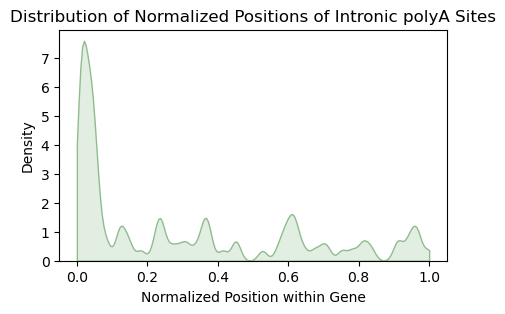

In [38]:
plt.figure(figsize=(5,3))

sns.kdeplot(intersection_df_rel_location['rel_loc'], fill=True, color='darkseagreen', bw_adjust=0.1, clip=(0,1))
plt.title('Distribution of Normalized Positions of Intronic polyA Sites')
plt.xlabel('Normalized Position within Gene')
plt.ylabel('Density')
# plt.savefig(os.path.join(figure_out_dir, 'intronic_pas_location.png'))
# plt.savefig(os.path.join(figure_out_dir, 'intronic_pas_location.svg'))
# plt.savefig(os.path.join(figure_out_dir, 'intronic_pas_location.jpg'))
plt.show()
